# TFGAN Tutorial

## Authors: Joel Shor, joel-shor

### More complex examples, see [`tensorflow/models/gan`](https://github.com/tensorflow/models/tree/master/research/gan)


This notebook will walk you through the basics of using [TFGAN](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/gan) to define, train, and evaluate Generative Adversarial Networks. We describe the library's core features as well as some extra features. This colab assumes a familiarity with TensorFlow's Python API. For more on TensorFlow, please see [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

Please note that running on GPU will significantly speed up the training steps, but is not required.

Last update: 2018-02-10.

## Table of Contents
<a href='#installation_and_setup'>Installation and Setup</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#download_data'>Download Data</a><br>
<a href='#unconditional_example'>Unconditional GAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_train'>Train and evaluation</a><br>
<a href='#ganestimator_example'>GANEstimator example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_train'>Train</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_eval'>Eval</a><br>
<a href='#conditional_example'>Conditional GAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_train'>Train and evaluation</a><br>
<a href='#infogan_example'>InfoGAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_train'>Train and evaluation</a><br>

<a id='installation_and_setup'></a>
## Installation and setup

To make sure that your version of TensorFlow has TFGAN included, run

```
python -c "import tensorflow.contrib.gan as tfgan"
```

You also need to install the TFGAN models library.

To check that these two steps work, execute the [`Imports`](#imports) cell. If it complains about unknown modules, restart the notebook after moving to the TFGAN models directory.

In [1]:
!python -c "import tensorflow.contrib.gan as tfgan"

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Make TFGAN models and TF-Slim models discoverable.
import sys
import os


#make sure we're in models/research/gan
print(os.getcwd())
import shoe_data_provider

os.chdir('../tf_experiment/models/research/gan')

# This is needed since the notebook is stored in the `tensorflow/models/gan` folder.
sys.path.append('..')
sys.path.append(os.path.join('..', 'slim'))

/Users/griggles/Documents/FLATIRON/FINAL PROJECT/Fashion/shoes


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



<a id='imports'></a>
### Imports

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow as tf



# Main TFGAN library.
tfgan = tf.contrib.gan

# TFGAN MNIST examples from `tensorflow/models`.
from mnist import data_provider
from mnist import util

# TF-Slim data provider.

#### need to figure out how to give shoes to this thing here vvvvvvv
from datasets import download_and_convert_mnist



# Shortcuts for later.
queues = tf.contrib.slim.queues
layers = tf.contrib.layers
ds = tf.contrib.distributions
framework = tf.contrib.framework

### Common functions

These functions are used by many examples, so we define them here.

In [4]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)
  

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()

def visualize_digits(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            images_np = sess.run(tensor_to_visualize)
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')

def evaluate_tfgan_loss(gan_loss, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            gen_loss_np = sess.run(gan_loss.generator_loss)
            dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

<a id='download_data'></a>
### Download data

In [5]:
#TWO CELLS WE NEED OT BE WORKING ON

# GET THE DATA


MNIST_DATA_DIR = 'tmp/mnist'




if not tf.gfile.Exists(MNIST_DATA_DIR):
    tf.gfile.MakeDirs(MNIST_DATA_DIR)

    
    ####PUT SHOES IN HERE vvv
    
    #this is downloading mnist data and converting to a .tfrecord...
    
    #we just converted to a tf record already... so we could just upload that tf 
    #record... (and put it in the samep place as MNIST_DATA_DIR and then not CALL
    #DOWNLOAD AND CONVERT... THEN THE DATA SHOULD BE POINTING AT OUR .tfrecord :)


download_and_convert_mnist.run(MNIST_DATA_DIR)

Dataset files already exist. Exiting without re-creating them.


In [6]:

### provide_data defined here

slim = tf.contrib.slim

###shoe dataset is stored as a numpy array
def get_shoe_dataset(split_name, dataset_dir):
    img_array = np.load('{}/{}_data_imgs.npy'.format(dataset_dir, split_name))
    lbl_array = np.load('{}/{}_data_lbls.npy'.format(dataset_dir, split_name))
    dataset = tf.data.Dataset.from_tensor_slices({'image': img_array, 'label': lbl_array})._dataset
    #dataset.data_sources = ['TENSORFLOW', 'SUCKS']
    #dataset.reader = 'FACK'
    return dataset
    

def provide_shoe_data(split_name, batch_size, dataset_dir, num_readers=1,
                 num_threads=1):
  """Provides batches of MNIST digits.

  Args:
    split_name: Either 'train' or 'test'.
    batch_size: The number of images in each batch.
    dataset_dir: The directory where the MNIST data can be found.
    num_readers: Number of dataset readers.
    num_threads: Number of prefetching threads.

  Returns:
    images: A `Tensor` of size [batch_size, 28, 28, 1]
    one_hot_labels: A `Tensor` of size [batch_size, mnist.NUM_CLASSES], where
      each row has a single element set to one and the rest set to zeros.
    num_samples: The number of total samples in the dataset.

  Raises:
    ValueError: If `split_name` is not either 'train' or 'test'.
  """
  dataset = get_shoe_dataset(split_name, dataset_dir)
    
    
  #THIS SHOULD BE RETURNING A MOFO'ING DATASET BUT IT RETURNS A DATASETV1ADAPTER WHATEVER
  #THAT IS!!!
    
  print(type(dataset))
  provider = slim.dataset_data_provider.DatasetDataProvider(
      dataset,
      num_readers=num_readers,
      common_queue_capacity=2 * batch_size,
      common_queue_min=batch_size, shuffle=(split_name == 'train'))

  [image, label] = provider.get(['image', 'label'])

  # Preprocess the images.
  image = (tf.to_float(image) - 128.0) / 128.0

  # Creates a QueueRunner for the pre-fetching operation.
  images, labels = tf.train.batch(
      [image, label],
      batch_size=batch_size,
      num_threads=num_threads,
      capacity=5 * batch_size)

  one_hot_labels = tf.one_hot(labels, dataset.num_classes)
  return images, one_hot_labels, dataset.num_samples


def float_image_to_uint8(image):
  """Convert float image in [-1, 1) to [0, 255] uint8.

  Note that `1` gets mapped to `0`, but `1 - epsilon` gets mapped to 255.

  Args:
    image: An image tensor. Values should be in [-1, 1).

  Returns:
    Input image cast to uint8 and with integer values in [0, 255].
  """
  image = (image * 128.0) + 128.0
  return tf.cast(image, tf.uint8)

In [7]:
#CREATE YOUR OWN DAMN DATA_PROVIDER
#shoe_dir = '/Users/griggles/Documents/FLATIRON/Final Project/Fashion/shoes/numpy'
#shoe_split_name = 'train'
#img_array = np.load('{}/{}_data_imgs.npy'.format(shoe_dir, shoe_split_name))
#shoe_images = tf.convert_to_tensor(img_array)
#lbl_array = np.load('{}/{}_data_lbls.npy'.format(shoe_dir, shoe_split_name))
#shoe_labels = tf.convert_to_tensor(lbl_array)
#items_to_tensors = {'images': shoe_images, 'labels': shoe_labels}
#num_samples = img_array.shape[0]
#shoe_data_provider = slim.data_provider.DataProvider(items_to_tensors, num_samples)

In [8]:
#items_to_tensors

In [9]:
dataset = get_shoe_dataset('test', '/Users/griggles/Documents/FLATIRON/Final Project/Fashion/shoes/numpy')

In [10]:
print(type(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [11]:
print(os.getcwd())

/Users/griggles/Documents/FLATIRON/FINAL PROJECT/Fashion/tf_experiment/models/research/gan


<a id='unconditional_example'></a>
# Unconditional GAN Example

With unconditional GANs, we want a generator network to produce realistic-looking digits. During training, the generator tries to produce realistic-enough digits to 'fool' a discriminator network, while the discriminator tries to distinguish real digits from generated ones. See the paper ['NIPS 2016 Tutorial: Generative Adversarial Networks'](https://arxiv.org/pdf/1701.00160.pdf) by Goodfellow or ['Generative Adversarial Networks'](https://arxiv.org/abs/1406.2661) by Goodfellow et al. for more details.

The steps to using TFGAN to set up an unconditional GAN, in the simplest case, are as follows:

1. **Model**: Set up the generator and discriminator graphs with a [`GANModel`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39) tuple. Use [`tfgan.gan_model`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L64) or create one manually.
1. **Losses**: Set up the generator and discriminator losses with a [`GANLoss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L115) tuple. Use [`tfgan.gan_loss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L328) or create one manually.
1. **Train ops**: Set up TensorFlow ops that compute the loss, calculate the gradients, and update the weights with a [`GANTrainOps`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) tuple. Use [`tfgan.gan_train_ops`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L476) or create one manually.
1. **Run alternating train loop**: Run the training Ops. This can be done with [`tfgan.gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661), or done manually.

Each step can be performed by a TFGAN library call, or can be constructed manually for more control.

In [12]:
SHOE_DATA_DIR = '/Users/griggles/Documents/FLATIRON/Final Project/Fashion/shoes/numpy'

#PROVIDES THE BATCH TENSOR
def provide_batch(split_name, batch_size, num_epochs, data_dir):
    img_array = np.load('{}/{}_data_imgs.npy'.format(data_dir, split_name)).astype(np.float32)
    lbl_array = np.load('{}/{}_data_lbls.npy'.format(data_dir, split_name)).astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((img_array, lbl_array))
    dataset = dataset.repeat(num_epochs)
    
    #set drop_remainder to True to force shape of tensor to have size 32 :)
    #(AND THEREFORE ACT LIKE THIS NOTEBOOK WAS BEFORE :))
    return dataset.batch(batch_size, drop_remainder=True).make_one_shot_iterator()
    

    

In [13]:
iterator =  provide_batch('train', 32, 1, SHOE_DATA_DIR)

W0206 05:30:57.940076 4634342848 deprecation.py:323] From <ipython-input-12-2fb68cf5507a>:12: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


<a id='unconditional_input'></a>
## Data input pipeline

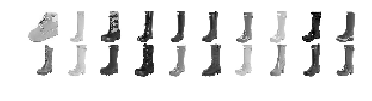

In [14]:
#CELL WE NEED TO BE AWARE OF
SHOE_DATA_DIR = '/Users/griggles/Documents/FLATIRON/Final Project/Fashion/shoes/numpy'

tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    #dataset = provide_shoe_data('train', batch_size, SHOE_DATA_DIR)._dataset
    #real_images, _, _ = shoe_data_provider.provide_data('train', batch_size, SHOE_DATA_DIR)
    iterator = provide_batch('train', batch_size, 1, SHOE_DATA_DIR)
    
    real_images = iterator.get_next()[0]

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:20,...], num_cols=10)
visualize_digits(check_real_digits)

#CELL WE NEED TO BE AWARE OF


#tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    
    #data_provider will add a dataset node to the graph... or something
    #what's a dataset node? A SOURCE NODE THAT SPITS OUT BATCHES OF TENSORS
    #INTO THE REST OF THE MODEL!
    real_images, _, _ = data_provider.provide_data(
        'train', batch_size, MNIST_DATA_DIR)
    
    
    #just fuckin figure out what this is doing ^ and fix it
    
#    print(real_images)

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:20,...], num_cols=10)
visualize_digits(check_real_digits)

In [15]:
real_images

<tf.Tensor 'IteratorGetNext:0' shape=(32, 28, 28, 1) dtype=float32>

<a id='unconditional_model'></a>
## Model

Set up a [GANModel tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39), which defines everything we need to perform GAN training. You can create the tuple with the library functions, or you can manually create one.

Define the GANModel tuple using the TFGAN library function.
For the simplest case, we need the following:

1. A generator function that takes input noise and outputs generated MNIST digits

1. A discriminator function that takes images and outputs a probability of  being real or fake

1. Real images

1. A noise vector to pass to the generator

### Generator

In [16]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

### Discriminator

In [17]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

### GANModel Tuple

W0206 05:31:06.228585 4634342848 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0206 05:31:06.469275 4634342848 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1624: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


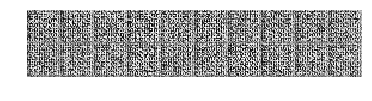

In [18]:
noise_dims = 64

#this is where the real_data gets passed in (As a tensor)


##### PROBLEM WITH PASSING DISCRIMINATOR ARGUMENTS... APPARENTLY SPECIFIED INT_64??
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
check_generated_digits = tfgan.eval.image_reshaper(
    gan_model.generated_data[:20,...], num_cols=10)
visualize_digits(check_generated_digits)

<a id='unconditional_loss'></a>
## Losses

We next set up the GAN model losses.

Loss functions are currently an active area of research. The [losses library](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/losses/python/losses_impl.py) provides some well-known or successful loss functions, such as the [original minimax](https://arxiv.org/abs/1406.2661), [Wasserstein](https://arxiv.org/abs/1701.07875) (by Arjovsky et al), and [improved Wasserstein](https://arxiv.org/abs/1704.00028) (by Gulrajani et al) losses. It is easy to add loss functions to the library as they are developed, and you can also pass in a custom loss function.

In [19]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

vanilla loss generator loss: -1.117800
vanilla loss discriminator loss: 1.500713
improved wgan loss generator loss: 0.154266
improved wgan loss discriminator loss: 0.052257
custom loss generator loss: -0.052407
custom loss discriminator loss: -0.030492


<a id='unconditional_train'></a>
## Training and Evaluation

### Train Ops
In order to train a GAN, we need to train both generator and discriminator networks using some variant of the alternating training paradigm. To do this, we construct a [GANTrainOps tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) either manually or with a library call. We pass it the optimizers that we want to use, as well as any extra arguments that we'd like passed to slim's `create_train_op` function.

In [20]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

W0206 05:31:26.576143 4634342848 training.py:421] update_ops in create_train_op does not contain all the update_ops in GraphKeys.UPDATE_OPS
W0206 05:31:26.890939 4634342848 training.py:421] update_ops in create_train_op does not contain all the update_ops in GraphKeys.UPDATE_OPS


### Evaluation

TFGAN provides some standard methods of evaluating generative models. In this example, we use a pre-trained classifier to calculate what is called the 'Inception Score' from [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) (by Salimans et al), which is a combined score of quality and diversity. We also calculate the 'Frechet Inception distance' from [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) (by Heusel et al), which measures how close the generated image distribution is to the real image distribution. 

In [21]:
num_images_to_eval = 500

#this is a saved classifier
MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'

# For variables to load, use the same variable scope as in the train job.
with tf.variable_scope('Generator', reuse=True):
    eval_images = gan_model.generator_fn(
        tf.random_normal([num_images_to_eval, noise_dims]),
        is_training=False)

# Calculate Inception score.
eval_score = util.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Calculate Frechet Inception distance.
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', num_images_to_eval, MNIST_DATA_DIR)
frechet_distance = util.mnist_frechet_distance(
    real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Reshape eval images for viewing.
generated_data_to_visualize = tfgan.eval.image_reshaper(
    eval_images[:20,...], num_cols=10)

W0206 05:31:27.419022 4634342848 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/contrib/gan/python/eval/python/classifier_metrics_impl.py:192: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0206 05:31:27.541882 4634342848 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/contrib/slim/python/slim/data/parallel_reader.py:242: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0206 05:31:27.548696 4634342848 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/training/i

DATA TENSOR
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("parallel_read/common_queue_Dequeue:1", dtype=string, device=/device:CPU:0)
<unknown>
END DATA TENSOR
['image', 'label']
TENSORS
<class 'list'>
[<tf.Tensor 'Reshape_3:0' shape=(28, 28, 1) dtype=uint8>, <tf.Tensor 'Reshape_4:0' shape=() dtype=int64>]
END OF TENSORS
[TensorShape([Dimension(28), Dimension(28), Dimension(1)]), TensorShape([])]
{'image': <tf.Tensor 'Reshape_3:0' shape=(28, 28, 1) dtype=uint8>, 'label': <tf.Tensor 'Reshape_4:0' shape=() dtype=int64>, 'record_key': <tf.Tensor 'parallel_read/common_queue_Dequeue:0' shape=<unknown> dtype=string>}
(28, 28, 1)


In [22]:
#inception score probably just takes a classifier that already works on the right distribution 
#and sees how it does on this new distribution. Kind of like an analogy between probability
#and likelihood. The score represents... 

### Train Steps

Now we're ready to train. TFGAN handles the alternating training scheme that arises from the GAN minmax game. It also gives you the option of changing the ratio of discriminator updates to generator updates. Most applications (distributed setting, borg, etc) will use the [`gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661) function, but we will use a different TFGAN utility and manually run the train ops so we can introspect more.

This code block should take about **1 minute** to run on a GPU kernel, and about **8 minutes** on CPU.

W0206 05:31:31.755888 4634342848 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py:826: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Current loss: 0.238460
Current MNIST score: 1.000075
Current Frechet distance: 335.367371
Training step: 0
Time since start: 0.200862 m
Steps per min: 0.000000


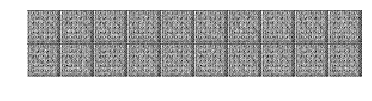

In [ ]:
# We have the option to train the discriminator more than one step for every 
# step of the generator. In order to do this, we use a `GANTrainSteps` with 
# desired values. For this example, we use the default 1 generator train step 
# for every discriminator train step.
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_scores, frechet_distances  = [], [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in xrange(1601):
        cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
        loss_values.append((i, cur_loss))
        if i % 200 == 0:
            mnist_score, f_distance, digits_np = sess.run(
                [eval_score, frechet_distance, generated_data_to_visualize])
            mnist_scores.append((i, mnist_score))
            frechet_distances.append((i, f_distance))
            print('Current loss: %f' % cur_loss)
            print('Current MNIST score: %f' % mnist_scores[-1][1])
            print('Current Frechet distance: %f' % frechet_distances[-1][1])
            visualize_training_generator(i, start_time, digits_np)

In [ ]:
# Plot the eval metrics over time.
plt.title('MNIST Frechet distance per step')
plt.plot(*zip(*frechet_distances))
plt.figure()
plt.title('MNIST Score per step')
plt.plot(*zip(*mnist_scores))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))